This notebook details the exploration and analysis of customer data from a video subscription company.

**NOTE: THE ACTUAL PROPRIETARY DATASETS HAVE NOT BEEN INCLUDED SINCE IT BELONGS TO THE COMPANY WHICH DESIRES TO REMAIN ANONYMOUS**

Main objective: 
Can we assign a likelihood percentage to each of our customers to measure their likelihood to churn within the next 30 days given their activity in the previous 30 days?

Note: Most of the metrics below are referring to customer activity in the previous 30 days (unless stated otherwise), and the "churned" variable is whether this customer ended up churning in the 30 days that followed.

------------------------------------------------------Variable definitions----------------------------------------------------

promo (factor variable): the promo group the customer was in

product_name: the streaming-video-on-demand (SVOD) subscription tier the customer was in (either Standard or Premium).
Promo group 2 is always the premium tier for free, promo group 5 can choose between Standard or Premium tier for free.
For promo groups 1,3,4  they will need to pay exactly $3 extra per month to be on the Premium tier.

churned (target variable): whether the customer cancelled their SVOD subscription in the following month

sub_six_months_ago (factor variable): whether customer had an existing SVOD subscription 6 months ago
sub_four_months_ago (factor variable): whether customer had an existing SVOD subscription 4 months ago

svod_total_hours: number of hours streamed
svod_series_count: number of shows streamed
svod_season_count: number of seasons streamed
svod_episode_count: number of episodes streamed
svod_days_count: number of days streamed
avg_daily_duration = svod_total_hours / svod_days_count : average number of hours streamed per day

keycontent_total_hours ...etc...same metrics as above but only for the 3 key tv shows we have. 
Every time a new season for one of these key shows gets put on our platform, the new season drives a lot of new 
and previously churned customers back to subscribe to the platform...but when the season finishes many of them 
churn as they only subscribed to the platform for that particular tv show. Customers might subscribe for the 
entire 3 months while the new episodes gets put on our platform weekly, or, customers may subscribe to the 
platform for only one month towards the end of the season to binge watch the whole season (so they don't have 
to subscribe to more than one month).

tvod_total_minutes: transactional-video-on-demand (TVOD) is our movie rental service, so number of minutes spent watching 
movies they rented
tvod_title_count: number of movie titles rented

svod_weekend_hours: number of hours customer spent watching tv shows in the weekends
svod_weekend_perc: the percentage of total SVOD hours watching in the weekends
svod_weekday_perc: the percentage of total SVOD hours watching in the weekdays  

svod_weekend_series_count...etc  same metrics as above but just for the weekend

svod_total_mins_lasttwoweeks: number of minutes streamed in the last two weeks (of the previous 30 days)
svod_total_mins_firsttwoweekes: number of minutes stream in the first two weeks (of the previous 30 days)
svod_duration_chg = svod_total_mins_lasttwoweeks - svod_total_mins_firsttwoweeks : whether customer streamed m
ore or less minutes over the previous 30 day period

portable_device_count: number of tablet/mobile devices used
non_portable_device_count : number of tv screens used

------------------------------------------------------------------------------------------------------------------------------

In [232]:
#Importing required libraries

import pandas as pd
import numpy as np
from sklearn import preprocessing, linear_model
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, auc, roc_curve, confusion_matrix


In [268]:

def evalBinaryClassifier(model, x, y, labels=['Positives','Negatives']):
    '''
    Visualize the performance of  a Logistic Regression Binary Classifier.
    
    Displays a labelled Confusion Matrix, distributions of the predicted
    probabilities for both classes, the ROC curve, and F1 score of a fitted
    Binary Logistic Classifier. Author: gregcondit.com/articles/logr-charts
    
    Parameters
    ----------
    model : fitted scikit-learn model with predict_proba & predict methods
        and classes_ attribute. Typically LogisticRegression or 
        LogisticRegressionCV
    
    x : {array-like, sparse matrix}, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples
        in the data to be tested, and n_features is the number of features
    
    y : array-like, shape (n_samples,)
        Target vector relative to x.
    
    labels: list, optional
        list of text labels for the two classes, with the positive label first
        
    Displays
    ----------
    3 Subplots
    
    Returns
    ----------
    F1: float
    '''
    #model predicts probabilities of positive class
    p = model.predict_proba(x)
    if len(model.classes_)!=2:
        raise ValueError('A binary class problem is required')
    if model.classes_[1] == 1:
        pos_p = p[:,1]
    elif model.classes_[0] == 1:
        pos_p = p[:,0]
    
    #FIGURE
    plt.figure(figsize=[15,4])
    
    #1 -- Confusion matrix
    cm = confusion_matrix(y,model.predict(x))
    plt.subplot(131)
    
    #Hide confidential subscriber numbers data, replace dummy with cm for real data
    dummy = np.array([[0, 0],
                     [0, 0]])
    ax = sns.heatmap(dummy, annot=True, cmap='Blues', cbar=False, 
                annot_kws={"size": 14}, fmt='g')
    cmlabels = ['True Negatives', 'False Positives',
              'False Negatives', 'True Positives']
    for i,t in enumerate(ax.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title('Confusion Matrix', size=15)
    plt.xlabel('Predicted Values', size=13)
    plt.ylabel('True Values', size=13)
      
    #2 -- Distributions of Predicted Probabilities of both classes
    df = pd.DataFrame({'probPos':pos_p, 'target': y})
    plt.subplot(132)
    plt.hist(df[df.target==1].probPos, density=True, bins=25,
             alpha=.5, color='green',  label=labels[0])
    plt.hist(df[df.target==0].probPos, density=True, bins=25,
             alpha=.5, color='red', label=labels[1])
    plt.axvline(.5, color='blue', linestyle='--', label='Boundary')
    plt.xlim([0,1])
    plt.title('Distributions of Predictions', size=15)
    plt.xlabel('Positive Probability (predicted)', size=13)
    plt.ylabel('Samples (normalized scale)', size=13)
    plt.legend(loc="upper right")
    
    #3 -- ROC curve with annotated decision point
    fp_rates, tp_rates, _ = roc_curve(y,p[:,1])
    roc_auc = auc(fp_rates, tp_rates)
    plt.subplot(133)
    plt.plot(fp_rates, tp_rates, color='green',
             lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
    #plot current decision point:
    tn, fp, fn, tp = [i for i in cm.ravel()]
    plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title('ROC Curve', size=15)
    plt.legend(loc="lower right")
    plt.subplots_adjust(wspace=.3)
    plt.show()
    #Print and Return the F1 score
    tn, fp, fn, tp = [i for i in cm.ravel()]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2*(precision * recall) / (precision + recall)
    printout = (
        f'Precision: {round(precision,2)} | '
        f'Recall: {round(recall,2)} | '
        f'F1 Score: {round(F1,2)} | '
    )
    print(printout)
    return F1

In [2]:
#Import .csv dataset
data = pd.read_csv('Customer_Churn_Dataset.csv')

Perform preliminary exploratory data analysis and data cleaning as needed.

In [3]:
#Any missing values?
data.isnull().any()

date                             False
account_id                       False
promo                            False
product_name                     False
churned                          False
sub_six_months_ago               False
sub_four_months_ago              False
svod_total_hours                 False
svod_series_count                False
svod_season_count                False
svod_episode_count               False
svod_days_count                  False
avg_daily_duration               False
keycontent_total_hours           False
keycontent_series_count          False
keycontent_season_count          False
keycontent_episode_count         False
keycontent_days_count            False
keycontent_avg_daily_duration    False
tvod_total_minutes               False
tvod_title_count                 False
svod_weekend_hours               False
svod_weekend_perc                False
svod_weekday_perc                False
svod_weekend_series_count        False
svod_weekend_season_count

In [258]:
#data.head()

In [259]:
#data.describe()

1. We can create a new column 'Paid' to denote whether or not the customer paid the extra $3 to subscribe by creating a new column 'Paid' with binary values of 0 and 1. (These are the customers in 'promo' group 1, 3, and 4 who also have a premium membership.)

2. Perform dummy encoding to 'product_name' column by having a new column 'product_name_Standard' with binary values of 0 or 1 to denote 'standard' (1) or 'premium' (0) membership.

In [6]:
#Create Series for new column 'Paid'
PaidColumn = pd.Series((data['promo']==1)|(data['promo']==3)|(data['promo']==4))&(data['product_name']=='Premium')

PaidColumn = (PaidColumn == True).astype(int)

In [7]:
#Dummy encoding for 'product_name' and create new dataframe 
cleanData = pd.get_dummies(data, columns=['product_name'], drop_first=True)

In [8]:
#Insert PaidColumn to cleanData
cleanData.insert(loc=len(cleanData.columns), column = "Paid", value = PaidColumn)

In [260]:
#cleanData

------------------**We were given an additional .csv file with additional features**----------------------

In [73]:
#import additional .csv file with additional features
data2 = pd.read_csv('churn_dataset_additional_vars.csv')

In [74]:
data2.isnull().any()

account_id                False
svod_lifetime_value       False
tvod_lifetime_value       False
kids_minutes              False
bigscreen_device_count    False
svod_bigscreen_minutes    False
svod_mins_celldata        False
svod_mins_wifi            False
svod_isp_spark            False
svod_isp_vodafone         False
svod_downloads            False
svod_1mon_0to6            False
svod_1mon_6to12           False
svod_1mon_12to18          False
svod_1mon_18to24          False
svod_2tue_0to6            False
svod_2tue_6to12           False
svod_2tue_12to18          False
svod_2tue_18to24          False
svod_3wed_0to6            False
svod_3wed_6to12           False
svod_3wed_12to18          False
svod_3wed_18to24          False
svod_4thu_0to6            False
svod_4thu_6to12           False
svod_4thu_12to18          False
svod_4thu_18to24          False
svod_5fri_0to6            False
svod_5fri_6to12           False
svod_5fri_12to18          False
svod_5fri_18to24          False
svod_6sa

In [75]:
print("Number of columns in data2: ", len(data2.columns))

Number of columns in data2:  39


In [261]:
#data2.describe()

In [77]:
#We want to merge both .csv files matching the account_id
combinedDF = pd.merge(cleanData, data2, on='account_id', how='inner', suffixes=(False, False))

In [262]:
#combinedDF.head()

We can perform PCA on the numeric variables in the dataset and observe to see if there are any interesting clusters.

In [92]:
#Standardize all the numeric columns excluding 'churned'
standardizedData = combinedDF.loc[:,combinedDF.columns[4:]]

In [95]:
scaler = preprocessing.StandardScaler()

standardizedData = pd.DataFrame(scaler.fit_transform(standardizedData), columns=[standardizedData.columns])

C:\Users\danth\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\danth\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [96]:
#Perform PCA on standardizedData dataframe
pca = PCA()

#Percentage of variance explained by each principle component
print('Explained Variance Ratios: ')
print(pca.fit(standardizedData).explained_variance_ratio_)

pcaData = pd.DataFrame(pca.fit_transform(standardizedData))

Explained Variance Ratios: 
[3.52052948e-01 7.54660153e-02 5.52437751e-02 3.93125755e-02
 3.65971873e-02 2.92287967e-02 2.70050514e-02 2.48271178e-02
 2.46876403e-02 1.85892910e-02 1.80686254e-02 1.55769296e-02
 1.48228585e-02 1.44324949e-02 1.31199292e-02 1.24445930e-02
 1.22207792e-02 1.00730281e-02 9.66773465e-03 9.12201519e-03
 8.62188464e-03 8.25502930e-03 7.94795269e-03 7.84243886e-03
 7.57720357e-03 7.45948266e-03 7.36545417e-03 7.10927593e-03
 6.82853596e-03 6.50093803e-03 6.46641674e-03 6.23131963e-03
 6.14026655e-03 6.01964775e-03 5.70775112e-03 5.55627073e-03
 5.46450888e-03 5.42514573e-03 5.12430928e-03 5.00352592e-03
 4.74163113e-03 4.70596240e-03 4.50424955e-03 4.44165941e-03
 4.23109262e-03 4.13803659e-03 4.02543294e-03 3.95767605e-03
 3.73462523e-03 3.41560760e-03 2.39379058e-03 2.29050225e-03
 1.54773127e-03 1.29348808e-03 1.19117779e-03 1.05652570e-03
 9.01794526e-04 4.80021218e-04 4.67809310e-04 4.18723175e-04
 3.96487513e-04 1.83868995e-04 1.38575450e-04 9.34769397e

**It seems the first three PCs can explain ~48% of the variance in the dataset**

In [106]:
#Combine pcaData with binary variables excluded earlier
combinedPCAdata = pd.concat([pcaData, combinedDF.loc[:, 'churned']], axis=1)

In [263]:
#Columns 0 to 66 are principle components 1 to 67
#combinedPCAdata.head()

We can plot the dataset with different combinations of PCs to visualize and see if there are any clusters.

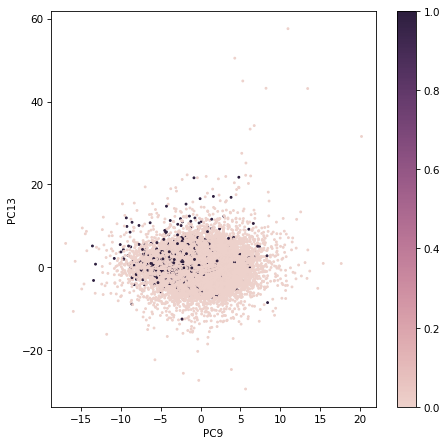

"cmap = sns.cubehelix_palette(as_cmap=True)\n\nf, ax = plt.subplots(figsize=(7, 7), dpi=75)\n\npoints = ax.scatter(combinedPCAdata[2], combinedPCAdata[3], c=combinedPCAdata['churned'], s=3, cmap=cmap)\n\nf.colorbar(points)\n\nplt.xlabel('PC3')\n\nplt.ylabel('PC4')\n\nplt.show()"

In [128]:
%matplotlib inline

cmap = sns.cubehelix_palette(as_cmap=True)

f, ax = plt.subplots(figsize=(7, 7), dpi=75)

points = ax.scatter(combinedPCAdata[8], combinedPCAdata[12], c=combinedPCAdata['churned'], s=3, cmap=cmap)

f.colorbar(points)

plt.xlabel('PC9')

plt.ylabel('PC13')

plt.show()

#Plotting next two PCs
"""cmap = sns.cubehelix_palette(as_cmap=True)

f, ax = plt.subplots(figsize=(7, 7), dpi=75)

points = ax.scatter(combinedPCAdata[2], combinedPCAdata[3], c=combinedPCAdata['churned'], s=3, cmap=cmap)

f.colorbar(points)

plt.xlabel('PC3')

plt.ylabel('PC4')

plt.show()"""

Likewise, we can do the same thing in 3D with any three PCs.

<IPython.core.display.Javascript object>


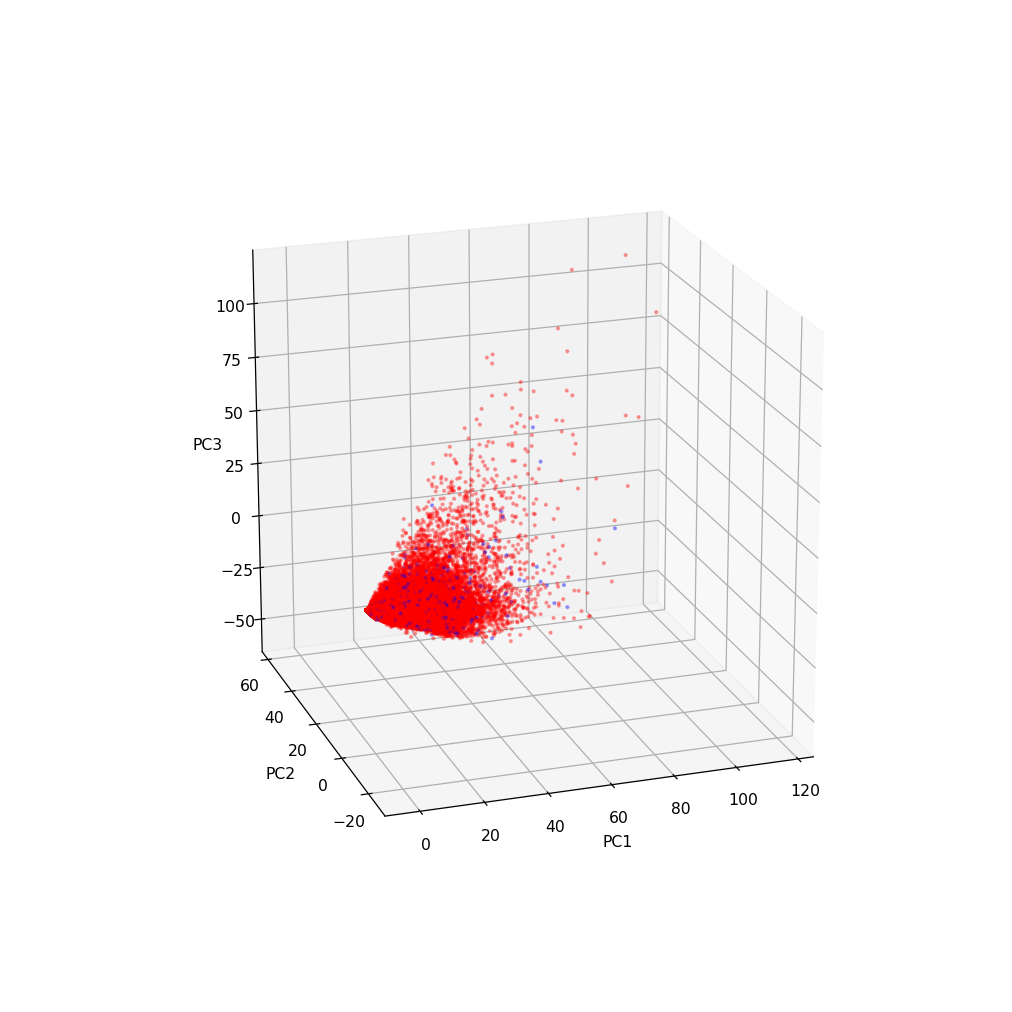

In [110]:
#Need to restart kernel to avoid problems with #matplotlib inline and #matplotlib notebook!
%matplotlib notebook

fig = plt.figure(figsize = (9, 9))

ax = fig.add_subplot(111, projection='3d')

colours = {0:'red', 1:'blue'}

ax.scatter(combinedPCAdata[0], combinedPCAdata[1], combinedPCAdata[2], s=3, c=combinedPCAdata['churned'].apply(lambda x: colours[x]), alpha=0.3)

ax.set_xlabel('PC1')

ax.set_ylabel('PC2')

ax.set_zlabel('PC3')

plt.show()

From the 2D plot with PCs 9 and 13 it seems there could be a decision boundary between the two classes.

Let's start exploring how well we can predict churn using logistic regression. Due to the class imbalance (having significantly less customers who have 'churned', we will perform stratified k-fold cross validation so that we have roughly equal distributions of 'churned' and not 'churned' customers in each training and validation set.

In [202]:
X_Features = standardizedData
Y_Target = combinedDF.loc[:, 'churned']

X_train, X_test, y_train, y_test = train_test_split(X_Features, Y_Target, test_size=0.3, stratify=Y_Target, random_state=1, shuffle=True)

#Standardize features since we are performing regularization
#scaler = preprocessing.StandardScaler()

#X_scaled = scaler.fit_transform(X_Features)

#Perform nested CV
#Set up stratified 5-fold cross validation (inner)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [203]:
#For each inner fold, train a logistic regression classifier and evaluate on validation set, tuning regularizer
model = LogisticRegressionCV(class_weight='balanced', cv=kfold, n_jobs=-1, scoring='roc_auc', max_iter=1000,
                            solver='newton-cg')

#Evaluate the classifier on independent test set using 'outer' kfold CV with 5 folds.
#aucScores = cross_val_predict(model, X=X_Features, y=Y_Target, cv=5)

model.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced',
           cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=1000, multi_class='warn', n_jobs=-1, penalty='l2',
           random_state=None, refit=True, scoring='roc_auc',
           solver='newton-cg', tol=0.0001, verbose=0)

In [205]:
#Print ROC_AUC score using test set
print('ROC_AUC score: ', model.score(X_test, y_test))

ROC_AUC score:  0.7435346773697449


C:\Users\danth\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1920: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


In [209]:
#Calculate the probabilities of being each class, and keeping only the probabilities of being in 'churned' class
probArray = model.predict_proba(X_test)[:,1]

Using our current logistic regression classifier with the threshold for detecting positive cases ('churned') set at 0.5, our classifier has extremely low recall. From the probability distribution plot, if we reduce our threshold we should be able to significantly increase our recall at the expense of precision.

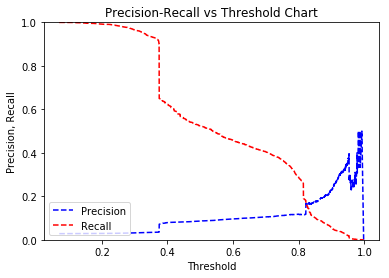

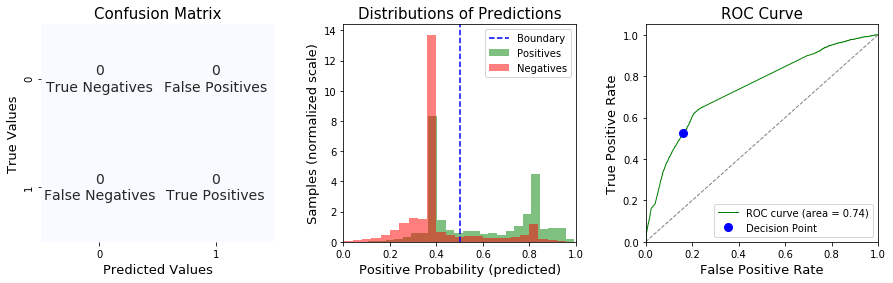

Precision: 0.09 | Recall: 0.52 | F1 Score: 0.15 | 


In [269]:
precision, recall, thresholds = precision_recall_curve(y_test, probArray) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

F1 = evalBinaryClassifier(model, X_test, y_test)

As we can see, our ROC curve gives us an auc score of 0.74 and setting the probability threshold at 0.5 gives us a precision of 0.09 and recall of 0.52. If we instead set the threshold at 0.4, we can increase our recall up to ~0.6 without a significant increase in our false positive rate.

In [237]:
features = pd.Series(data=combinedDF.columns[4:], name='Features')

In [242]:
coefficients = pd.Series(data=model.coef_[0], name='Coefficients')

Using the logistic regression coefficients, we can sort them from most positive to most negative in order to get an idea of which features correlate with 'churn'.

In [251]:
logitFeatures = {'Features':features, 'Coefficients':coefficients}

In [252]:
logitFeaturesDF = pd.DataFrame(logitFeatures, columns=['Features','Coefficients'])

In [256]:
logitFeaturesDF.sort_values(by=['Coefficients'], inplace=True, ascending=False)

In [257]:
logitFeaturesDF

,Features,Coefficients
29,svod_lifetime_value,0.325839
4,svod_season_count,0.082995
8,keycontent_total_hours,0.055475
23,svod_total_mins_firsttwoweeks,0.044759
45,svod_2tue_12to18,0.041223
5,svod_episode_count,0.039676
11,keycontent_episode_count,0.039544
66,svod_7sun_18to24,0.039087
14,tvod_total_minutes,0.038097
58,svod_5fri_18to24,0.036030
